In [49]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import hist
from hist import Hist
import os, sys
import json
import h5py
import awkward as ak
import uproot
import pickle
import vector
import mplhep as hep
vector.register_awkward()

# parameters for matplotlib styling
plt.style.use(hep.style.CMS)
matplotlib.rcParams.update({'figure.max_open_warning': 0})
matplotlib.rcParams.update({'font.size': 20})

In [54]:
# parameters for input files
plotDir = os.environ['HOME']+"/SUEPCoffea_dask/plotting/"
infile_name = plotDir+'mult_ABCD_plot.pkl'
unblind = False                               # don't show D_exp for SUEP
save_to_file = ['A','B']                      # set to 'all' or list of plots or plot name
output_label = 'SUEP'

In [55]:
# load files from pickle
with (open(infile_name, "rb")) as openfile:
    plots = pickle.load(openfile)

In [67]:
def plot1d(label, save=False):
    h = plots[label]
    fig, ax = plt.subplots(figsize=(8,5))
    hep.cms.label(data=False,year='2018', fontsize=20)
    values, x = h.to_numpy()
    ax.step(x[:-1],values)
    ax.set_xlabel(h.axes[0].name)
    ax.set_ylabel("Events")
    if save: fig.savefig(output_label + "_" + label+".pdf", bbox_inches='tight')
    
def plot2d(label, save=False):
    h = plots[label]
    fig, ax = plt.subplots(figsize=(8,5))
    hep.cms.label(data=False,year='2018', fontsize=20)
    w, x, y = h.to_numpy()
    mesh = ax.pcolormesh(x, y, w.T, cmap="RdYlBu")
    ax.set_xlabel(h.axes[0].name)
    ax.set_ylabel(h.axes[1].name)
    fig.colorbar(mesh)
    if save: fig.savefig(output_label + "_" + label+".pdf", bbox_inches='tight')

In [68]:
# define a savelist of plots to save to file
if type(save_to_file) == str and save_to_file == 'all': 
    savelist = list(plots.keys())
    print("Saving plots", list(savelist))
elif type(save_to_file) == str and save_to_file in plots.keys():
    savelist = [save_to_file]
    print("Saving plot: ", savelist)
elif type(save_to_file) == list: 
    savelist = save_to_file
    print("Saving plots: ", savelist)

Saving plots:  ['A', 'B']


Histogram dphi_chcands_ISR is empty
Histogram dphi_SUEPtracks_ISR is empty
Histogram dphi_ISRtracks_ISR is empty
Histogram dphi_SUEP_ISR is empty


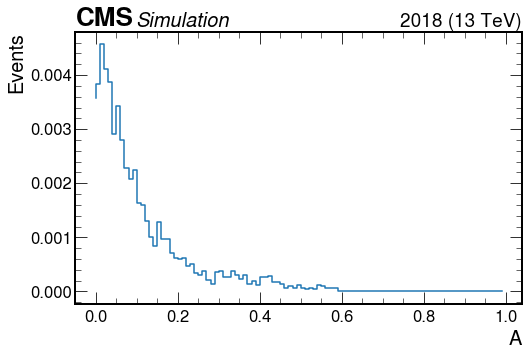

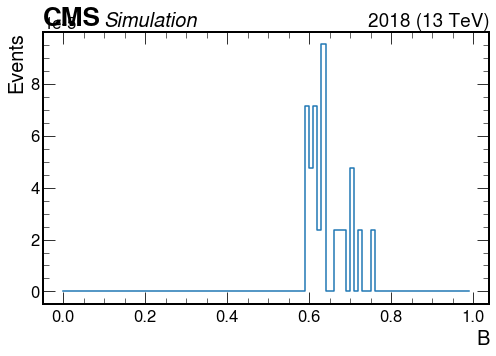

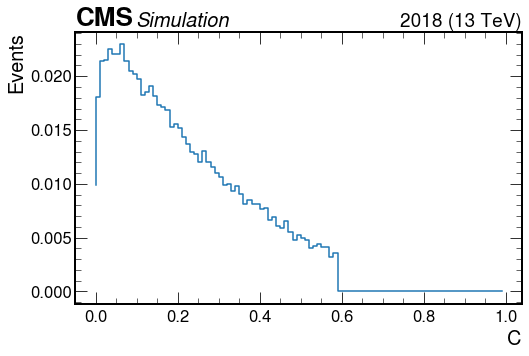

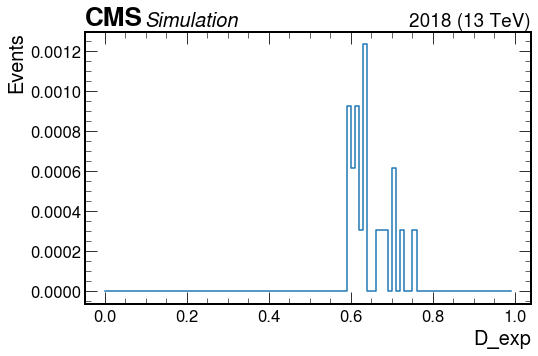

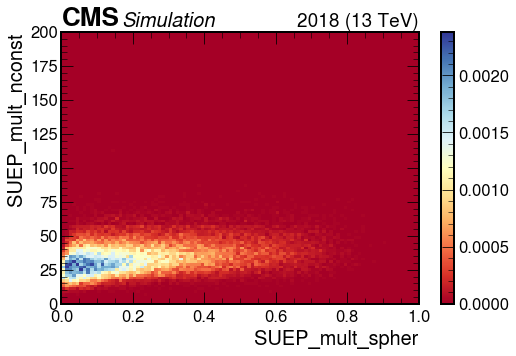

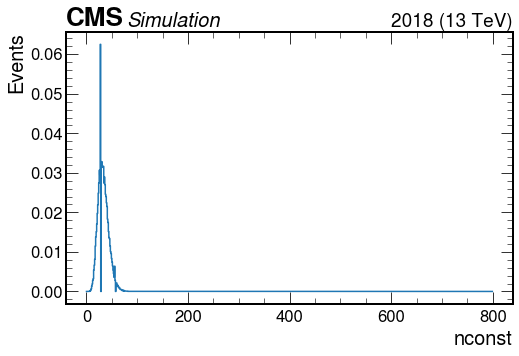

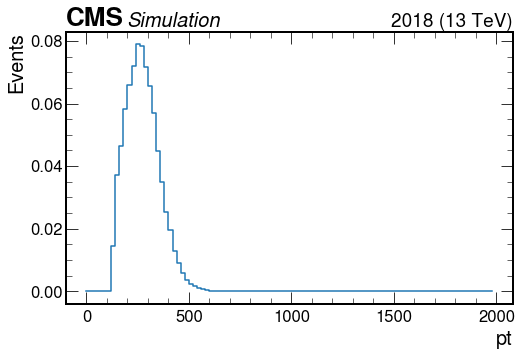

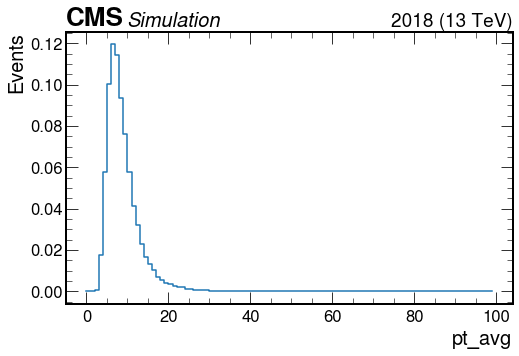

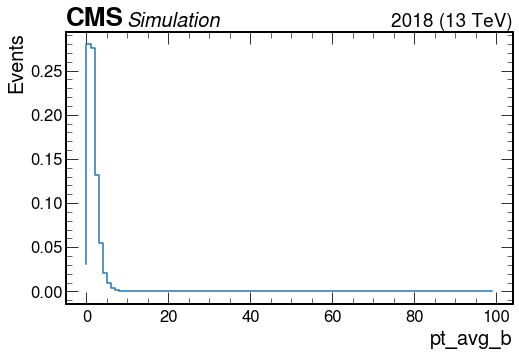

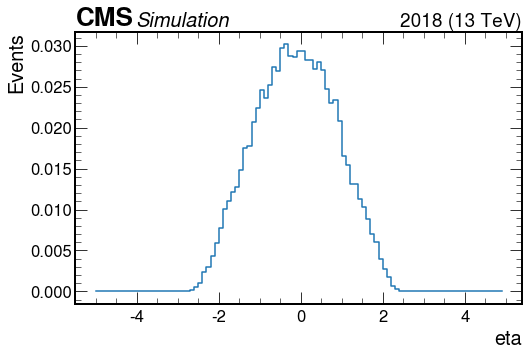

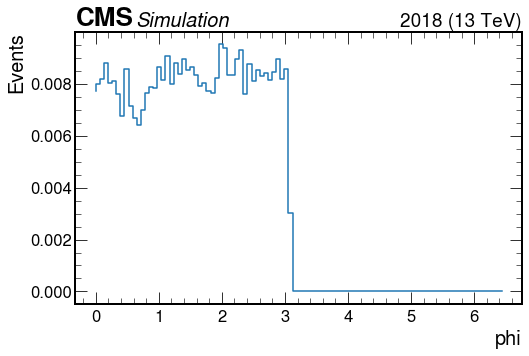

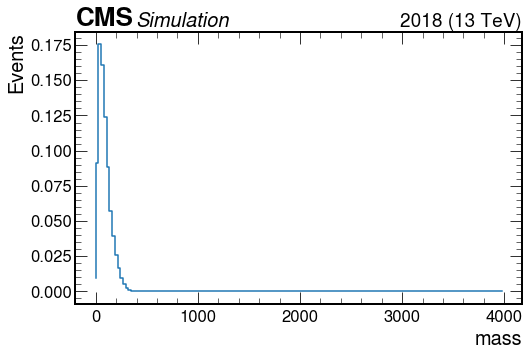

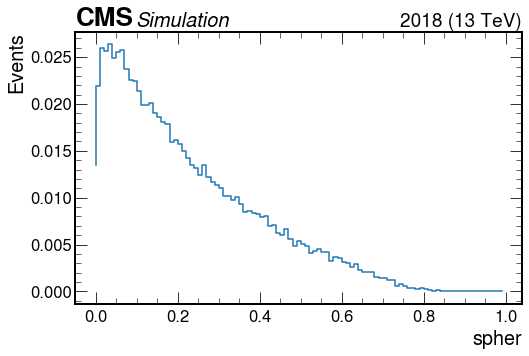

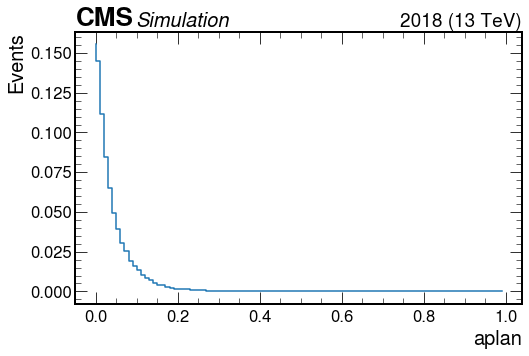

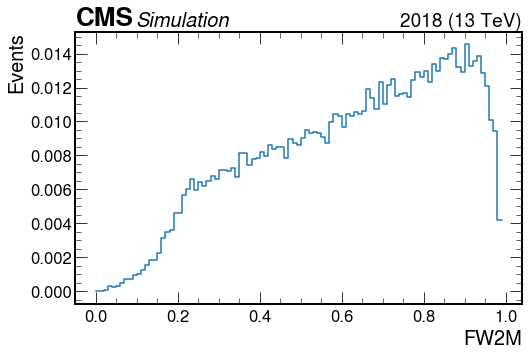

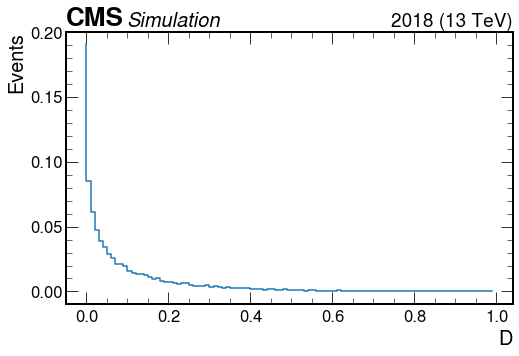

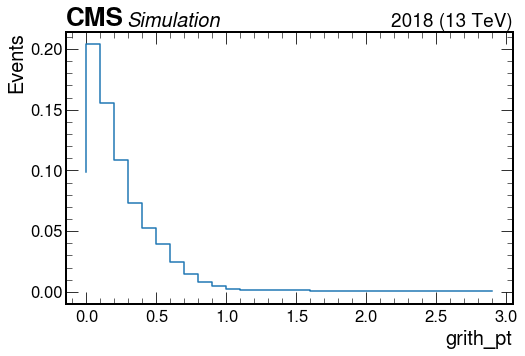

In [69]:
for label in plots.keys():
    if 'D_obs' in label and (not unblind): continue
    if plots[label].sum().value == 0:
        print('Histogram',label,'is empty')
        continue
        
    save = label in savelist
    if '2D' in label: plot2d(label, save)
    else: plot1d(label, save)